In [3]:
import os, sys
import numpy as np
top_dir = os.getcwd().split('ipython_nb')[0]
sys.path.append(top_dir+ 'v4cnn/')
sys.path.append( top_dir + 'xarray');top_dir = top_dir + 'v4cnn/';
sys.path.append( top_dir + 'common/')
sys.path.append(top_dir +'/nets')
import caffe_net_response as cf
import matplotlib
from matplotlib.ticker import FuncFormatter
import pickle as pk
import xarray as xr;import pandas as pd
import apc_model_fit as ac
import matplotlib.ticker as mtick;
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import d_plot as dp
import scipy.io as  l
import d_curve as dc
import d_img_process as imp
%matplotlib inline  

In [4]:
fn = 'bvlc_reference_caffenetAPC362_pix_width[30.0]_pos_(64.0, 164.0, 101)_analysis.p'
try:
    an=pk.load(open(top_dir + 'data/an_results/' + fn,'rb'), 
               encoding='latin1')
except:
    an=pk.load(open(top_dir + 'data/an_results/' + fn,'rb'))
    
fvx = an[0].sel(concat_dim='r2')
rf = an[0].sel(concat_dim='rf')
cnn = an[1]
v4_name = 'V4_370PC2001'
v4_resp_apc = xr.open_dataset(top_dir + 'data/responses/' + v4_name + '.nc')['resp'].load()
v4_resp_apc = v4_resp_apc.transpose('shapes', 'unit')
no_rotation = [0, 1, 2, 10, 14, 18, 26,30, 38, 46, 54, 62, 70, 78, 86, 94,102, 110, 118, 126, 134,
 142, 150, 158,166, 174, 182, 190,198, 206, 214, 222, 224, 232, 236, 244, 252, 254, 
 262, 270, 278, 286, 294, 302, 310, 314, 322, 330, 338, 346, 354, ]

no_rotation = [0, 1, 2, 10, 18, 22,30,34,42, 50, 58, 66, 74, 82,  90, 98, 106, 114, 122, 130, 138,
 146, 154, 162,170, 178, 186, 194, 202, 210, 218, 226, 228, 236, 240, 248, 256, 
 258, 266, 274, 282, 290, 298, 306, 314, 322, 330, 338, 346, 354, 362,370 ]
rot_shape_resp_list = []
rot_shape_id_list = []
for i, s_ind in enumerate(no_rotation):
    if i < len(no_rotation)-1:
        last_rot = no_rotation[i+1]
    else:
        last_rot = 370
    rot_shape_resp_list.append(v4_resp_apc[s_ind:last_rot, 0].values)
    rot_shape_id_list.append(np.arange(s_ind, last_rot))
#print(rot_shape_id_list)

In [5]:
max_pix_width = [64.,]
img_n_pix = 70
s = l.loadmat(top_dir + 'img_gen/PC3702001ShapeVerts.mat')['shapes'][0]
base_stack = dc.center_boundary(s)
boundaries = imp.center_boundary(s)
scale = max_pix_width/dc.biggest_x_y_diff(boundaries)
shape_ids = range(-1, 370); center_image = round(img_n_pix/2)
x = (center_image, center_image, 1);y = (center_image, center_image, 1)
stim_trans_cart_dict, stim_trans_dict = cf.stim_trans_generator(shapes=shape_ids, scale=scale, x=x, y=y)
trans_img_stack = np.array(imp.boundary_stack_transform(stim_trans_cart_dict, base_stack, npixels=img_n_pix))
#plot smallest and largest shape
no_blank_image = trans_img_stack[1:]

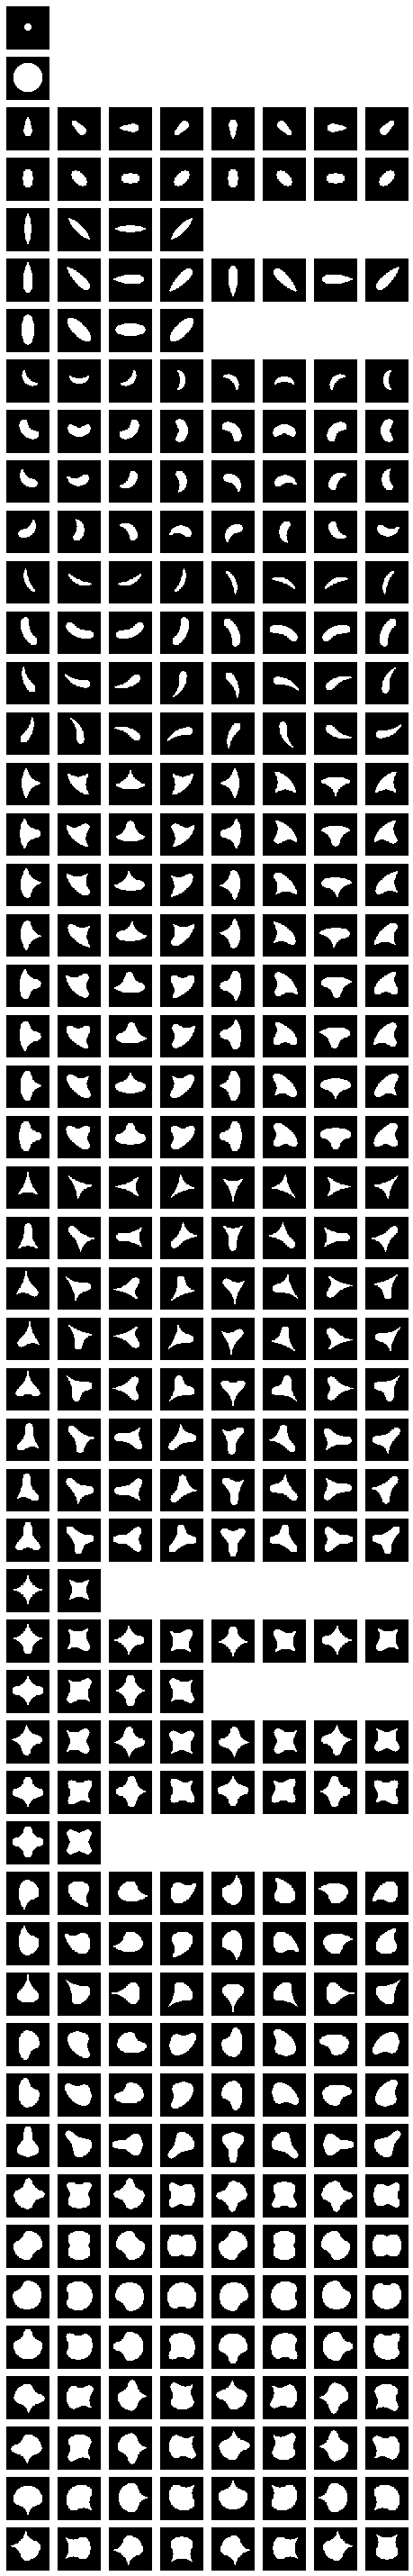

In [6]:
m = 51
n = 8
import matplotlib.gridspec as gridspec
plt.figure(figsize=(8/1.,51/1.))
plot_id = np.arange(0, m*n).reshape(m, n)
gs = gridspec.GridSpec(m, n)

m_ind = 0
n_ind = 0
for shape_id_set in rot_shape_id_list:
    for shape_id in shape_id_set:
        p_num = plot_id[m_ind, n_ind]
        ax = plt.subplot(gs[p_num])
        ax.imshow(no_blank_image[shape_id].squeeze(), interpolation = 'nearest', cmap=plt.cm.Greys_r)
        ax.set_xticks([]);ax.set_yticks([]);
        n_ind+=1
    n_ind=0
    m_ind+=1 
#plt.tight_layout()

In [7]:
def rotate_responses(resp, shape_id, rot=1):
    rot_resp = []
    for a_shape in shape_id:
        for a_ori_ind in range(len(a_shape)):
            rot_resp.append(resp[a_shape[(a_ori_ind+rot)%len(a_shape)]])
    return rot_resp
rot_resp = rotate_responses(np.arange(0,370), 
                            rot_shape_id_list, 
                            rot=1)
print(rot_resp[:25])

[0, 1, 3, 4, 5, 6, 7, 8, 9, 2, 11, 12, 13, 14, 15, 16, 17, 10, 19, 20, 21, 18, 23, 24, 25]


(7, 109, 370)
[21101  2360  7760 ...,  1236 15477 56544]
(83167, 3)
0.802408493936
(4, 82, 82)
0.793844299951
(1, 32, 108)
0.706604754599
(0, 11, 37)
0.706604754599
(0, 37, 11)
0.699743770498
(3, 26, 64)
0.699743770498
(5, 64, 26)
0.665095800406
(2, 37, 90)
0.665095800406
(6, 90, 37)
0.648950140197
(3, 0, 108)


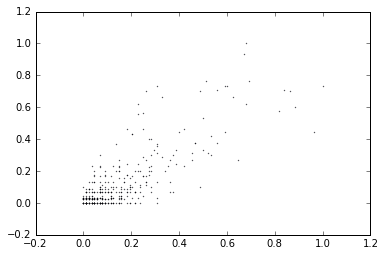

In [8]:
rotations = []
for rot in range(0,7):
    rotations.append(
    [rotate_responses(unit.squeeze(), rot_shape_id_list, rot) 
    for unit in v4_resp_apc.values.T])

rotations = np.array(rotations)
flat_rotations = rotations.reshape(np.product(rotations.shape[:-1]), rotations.shape[-1])
cor = np.corrcoef(flat_rotations)[..., :109]
print(rotations.shape)
'''
plt.figure(figsize=(8.,51.))
plt.imshow(cor>0.8, interpolation = 'nearest', cmap=plt.cm.Greys_r)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
_=plt.colorbar()
_=plt.figure(figsize=(12,4))
'''
#_=plt.hist(cor, bins=100)
#plt.xticks(np.round(np.linspace(0,1,11),1))

cor = np.corrcoef(flat_rotations)[..., :109].reshape(7,109,109)
cor[cor>.99] = 0

best_cor = cor.ravel().argsort(axis=None)
print(best_cor)

best_inds = [np.unravel_index(ind, cor.shape) for ind in best_cor]
print(np.array(best_inds).shape)
for ind in range(1,10):
    print(cor[best_inds[-ind]])
    print(best_inds[-ind])

#print(cor.max())
#print(max_ind
plt.scatter(rotations[1, 32, :], rotations[0, 108, :], s=0.1)

In [9]:
np.corrcoef(rotations[1, 32, :], rotations[0, 108, :])

array([[ 1.       ,  0.7938443],
       [ 0.7938443,  1.       ]])

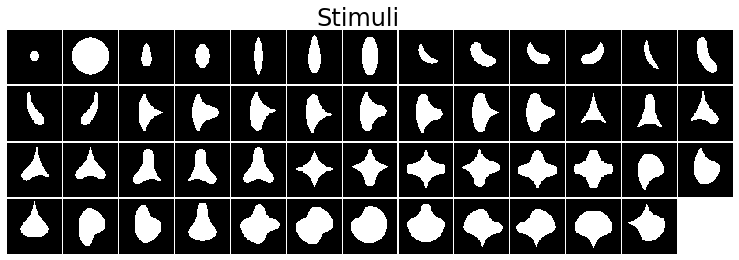

In [28]:
plt.figure(figsize=(13,4), )
plot_id = np.arange(0, m*n).reshape(m, n)
gs = gridspec.GridSpec(4,13)
gs.update(wspace=0.0, hspace=0.0)

m_ind = 0
n_ind = 0
p_num = -1
for shape_id_set in rot_shape_id_list[:-1]:
    p_num += 1 
    ax = plt.subplot(gs[p_num])
    ax.imshow(no_blank_image[shape_id_set[0]].squeeze(), interpolation = 'nearest', cmap=plt.cm.Greys_r)        
    ax.set_xticks([]);ax.set_yticks([]);
plt.suptitle('Stimuli', fontsize=24)
#plt.tight_layout()


In [19]:
len(rot_shape_id_list)

52